In [14]:
import os
import sys

# Move up to the correct project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

print("Updated Python path:", sys.path)  # Debugging check


Updated Python path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env', '', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\D

# Consolidated Backtesting Notebook
 In this notebook we run and compare three trading strategies:
 1. Moving Average Crossover Strategy
 2. 500-Days Halving Strategy
 3. DQN Agent Strategy


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

## 1. Moving Average Strategy Backtest
This function implements the moving average crossover strategy. It returns the full DataFrame (with backtest results)
and a dictionary of metrics including final portfolio value, profit, annualized return, Sharpe ratio, maximum drawdown,
win rate, and loss rate.

In [16]:
def moving_average_backtest(data, short_window=24, long_window=96, initial_capital=10000):
    df = data.copy()
    # Calculate moving averages
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()
    
    # Generate signals: 1 for long when short_ma > long_ma, -1 for short otherwise.
    df['signal'] = 0
    df.loc[df.index[long_window:], 'signal'] = np.where(
        df['short_ma'].loc[df.index[long_window:]] > df['long_ma'].loc[df.index[long_window:]], 1, -1
    )
    
    # Identify position changes (trading events)
    df['position_change'] = df['signal'].diff()
    
    # Compute returns and strategy returns
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
    df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
    df['portfolio_value'] = initial_capital * df['cumulative_returns']
    
    final_portfolio_value = df['portfolio_value'].iloc[-1]
    profit = final_portfolio_value - initial_capital

    # Annualized Return
    time_period = (df.index[-1] - df.index[0]).total_seconds() / (365.25 * 24 * 3600)
    annualized_return = (final_portfolio_value / initial_capital) ** (1 / time_period) - 1

    # Sharpe Ratio (risk-free rate assumed 0, hourly annualization)
    mean_ret = df['strategy_returns'].mean()
    std_ret = df['strategy_returns'].std()
    annual_factor = 365.25 * 24
    sharpe_ratio = (mean_ret / std_ret) * np.sqrt(annual_factor) if std_ret != 0 else np.nan

    # Maximum Drawdown
    df['running_max'] = df['portfolio_value'].cummax()
    df['drawdown'] = df['portfolio_value'] / df['running_max'] - 1
    max_drawdown = df['drawdown'].min()

    # Win Rate & Loss Rate via trade-by-trade returns
    trade_signals = df[df['position_change'] != 0][['close', 'signal']].sort_index()
    trades = []
    for i in range(len(trade_signals) - 1):
        entry = trade_signals.iloc[i]
        exit = trade_signals.iloc[i+1]
        if entry['signal'] == 1:
            trade_return = exit['close'] / entry['close'] - 1
        elif entry['signal'] == -1:
            trade_return = entry['close'] / exit['close'] - 1
        else:
            continue
        trades.append(trade_return)
    trades = np.array(trades)
    win_rate = np.sum(trades > 0) / len(trades) if len(trades) > 0 else np.nan
    loss_rate = np.sum(trades < 0) / len(trades) if len(trades) > 0 else np.nan

    metrics = {
        "final_portfolio_value": final_portfolio_value,
        "profit": profit,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "win_rate": win_rate,
        "loss_rate": loss_rate
    }
    
    return df, metrics

Load raw Bitcoin price data for moving average strategy

In [17]:
ma_data = pd.read_csv("../Transform_data/raw_data/2023-2018_BTC-USD_Data_1h.csv")
ma_data['date'] = pd.to_datetime(ma_data['date'], format='%d.%m.%Y %H:%M')
ma_data.sort_values('date', inplace=True)
ma_data.set_index('date', inplace=True)

df_ma, metrics_ma = moving_average_backtest(ma_data)
print("Moving Average Strategy Metrics:")
for k, v in metrics_ma.items():
    print(f"{k}: {v}")

Moving Average Strategy Metrics:
final_portfolio_value: 14968.966474319996
profit: 4968.9664743199955
annualized_return: 0.074267021257717
sharpe_ratio: 0.4514172620377163
max_drawdown: -0.6698768770151349
win_rate: 0.3
loss_rate: 0.7


(Optional) Plot the portfolio value evolution for Moving Average strategy

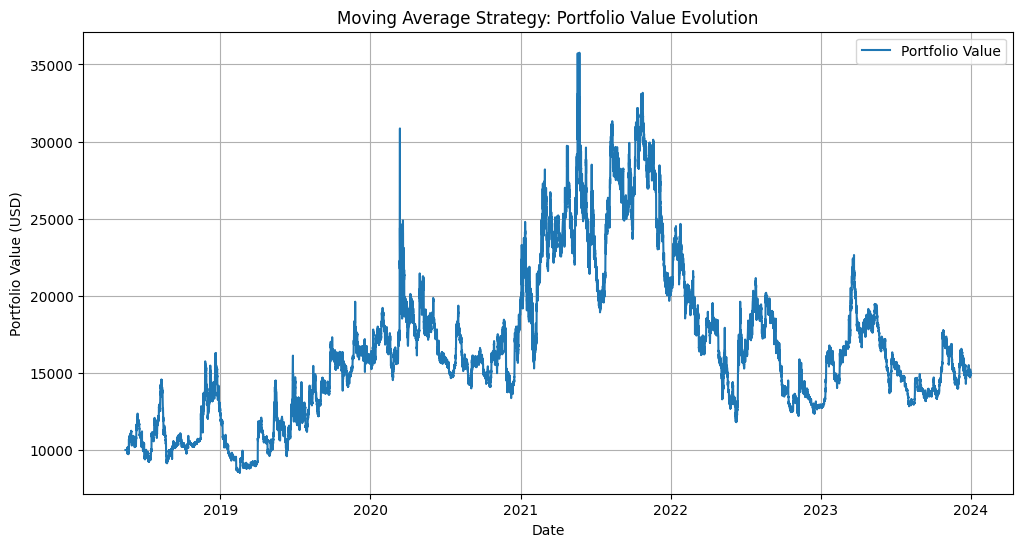

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_ma.index, df_ma['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.title('Moving Average Strategy: Portfolio Value Evolution')
plt.legend()
plt.grid(True)
plt.show()

## 2. 500-Days Halving Strategy Backtest

This section replicates the halving strategy notebook.
It downloads BTC data via yfinance and computes cumulative growth based on 500-day cycles around halving events.


In [19]:
def halving_strategy_backtest():
    from datetime import datetime, timedelta
    import numpy as np
    import pandas as pd
    import yfinance as yf

    # Define halving dates (include future prediction if desired)
    halving_dates = [
        datetime(2016, 7, 9),
        datetime(2020, 5, 11),
        datetime(2024, 4, 21)  # Predicted future date
    ]
    start_date = datetime(2010, 1, 1)
    end_date = datetime.now() - timedelta(days=3)

    # Download BTC data from yfinance
    btc_data = yf.download("BTC-USD", start=start_date, end=end_date)
    btc_data.index = pd.to_datetime(btc_data.index)

    initial_cash = 10_000
    final_results = pd.Series(dtype=float)
    current_value = initial_cash  # Start with 10,000 cash
    trade_returns = []            # To store trade-by-trade returns for each halving period

    # For buy-and-hold comparison, use data starting 500 days before first halving date
    first_period_start = max(start_date, halving_dates[0] - timedelta(days=500))
    buy_and_hold_data = btc_data[btc_data.index >= first_period_start]
    buy_and_hold_start_price = buy_and_hold_data.iloc[0]['Close']
    buy_and_hold_growth = (buy_and_hold_data['Close'] / buy_and_hold_start_price) * initial_cash

    # Loop over each halving date and process a 1000-day window (500 days before to 500 days after)
    for halving_date in halving_dates:
        date_before = max(start_date, halving_date - timedelta(days=500))
        date_after = halving_date + timedelta(days=500)
        data_in_range = btc_data[(btc_data.index >= date_before) & (btc_data.index <= date_after)]
        if data_in_range.empty:
            continue

        price_before = data_in_range.iloc[0]['Close']
        # Calculate portfolio value changes for this segment based on price changes
        daily_portfolio = (data_in_range['Close'] / price_before) * current_value

        # Append daily portfolio values to final results
        if not final_results.empty:
            final_results = pd.concat([final_results, daily_portfolio])
        else:
            final_results = daily_portfolio

        # Calculate trade return for this halving window
        period_return = (daily_portfolio.iloc[-1] / daily_portfolio.iloc[0]) - 1
        trade_returns.append(period_return)

        # Update current_value for compounding
        current_value = daily_portfolio.iloc[-1]

    # Final portfolio value and annualized return calculation
    if not final_results.empty:
        final_growth = final_results.iloc[-1].item()
        time_period = (final_results.index[-1] - final_results.index[0]).total_seconds() / (365.25 * 24 * 3600)
        initial_value = final_results.iloc[0].item()
        if initial_value > 0:
            annualized_return = (final_results.iloc[-1].item() / initial_value) ** (1 / time_period) - 1
        else:
            annualized_return = np.nan
    else:
        final_growth = np.nan
        annualized_return = np.nan

    # Buy-and-hold final value (scaled to initial cash)
    buy_and_hold_final = buy_and_hold_growth.iloc[-1].item()

    # Compute Sharpe Ratio
    strategy_returns = final_results.pct_change().dropna()
    if not strategy_returns.empty and strategy_returns.std().item() != 0:
        annual_factor = 365.25 * 24  # Hourly annualization
        sharpe_ratio = (strategy_returns.mean().item() / strategy_returns.std().item()) * np.sqrt(annual_factor)
    else:
        sharpe_ratio = np.nan

    # Compute Maximum Drawdown
    running_max = final_results.cummax()
    drawdown = final_results / running_max - 1
    max_drawdown = drawdown.min().item()

    # Win Rate & Loss Rate based on trade returns
    trade_returns = np.array(trade_returns)
    if len(trade_returns) > 0:
        win_rate = np.sum(trade_returns > 0) / len(trade_returns)
        loss_rate = np.sum(trade_returns < 0) / len(trade_returns)
    else:
        win_rate = np.nan
        loss_rate = np.nan

    # Prepare the metrics dictionary
    metrics = {
        "final_portfolio_value": final_growth,
        "buy_and_hold_final": buy_and_hold_final,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "win_rate": win_rate,
        "loss_rate": loss_rate
    }

    return btc_data, final_results, buy_and_hold_growth, metrics


In [20]:
btc_data, final_results, buy_and_hold_growth, metrics_halving = halving_strategy_backtest()
print("\nHalving Strategy Metrics:")
for k, v in metrics_halving.items():
    print(f"{k}: {v}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Halving Strategy Metrics:
final_portfolio_value: 18919498.45054328
buy_and_hold_final: 3530711.4269804587
annualized_return: 1.1099535298299483
sharpe_ratio: 8.948592278545496
max_drawdown: -0.6181085049983791
win_rate: 1.0
loss_rate: 0.0


(Optional) Plot the cumulative growth from halving strategy vs. buy-and-hold

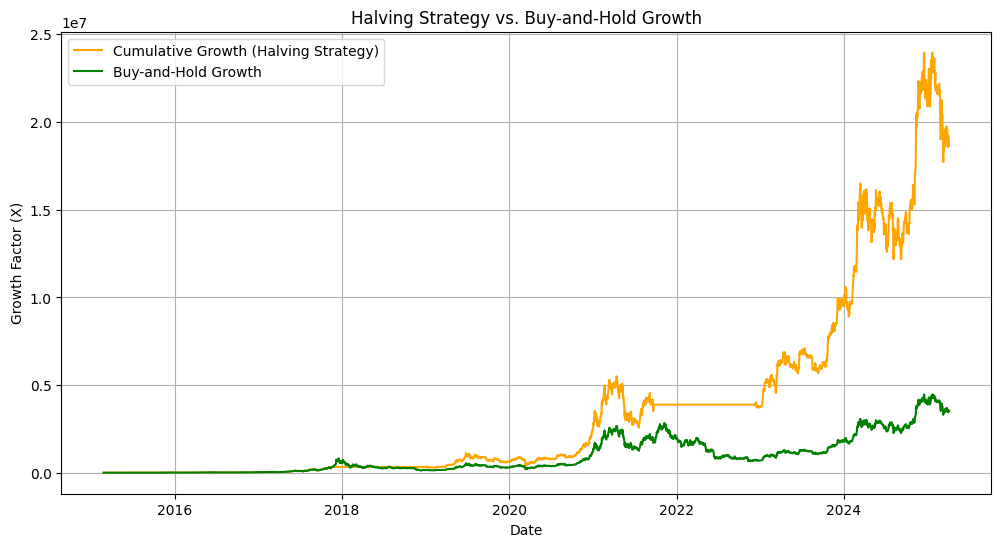

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(final_results.index, final_results, color='orange', label='Cumulative Growth (Halving Strategy)')
plt.plot(buy_and_hold_growth.index, buy_and_hold_growth, color='green', label='Buy-and-Hold Growth')
plt.xlabel("Date")
plt.ylabel("Growth Factor (X)")
plt.title("Halving Strategy vs. Buy-and-Hold Growth")
plt.legend()
plt.grid(True)
plt.show()

## 3. DQN Agent Strategy Backtest

This section uses a trained DQN agent and your custom TradingEnv to run a test episode.
(Ensure that the TradingEnv class, scaler, and model file are available in the specified paths.)


In [10]:
def dqn_agent_backtest():
    from stable_baselines3 import DQN
    from stable_baselines3.common.vec_env import DummyVecEnv
    import pandas as pd
    # If your TradingEnv is defined in a separate module, import it:
    # from Environment.environment import TradingEnv
    
    # Load test data (ensure your CSV path is correct)
    test_data = pd.read_csv("../Transform_data/stand_data/2025-2024_stand_data.csv")
    test_data.drop('datetime', axis=1, inplace=True)
    


    from Environment.environment import TradingEnv
    
    env = TradingEnv(
        data=test_data,
        initial_cash=10000,
        window_size=336,
        scaler_path="../Transform_data/scaler.pkl",
        default_seed=42
    )
    
    # Load the pre-trained DQN model
    try:
        model = DQN.load("../Backtesting/model_without_buffer", custom_objects={"replay_buffer": None})
    except Exception as e:
        raise RuntimeError(f"Failed to load DQN model: {e}")
    
    obs, info = env.reset(seed=42)
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(int(action))
    
    # Compute metrics using the portfolio value history from the environment.
    # Ensure that your TradingEnv maintains a list or array of portfolio values in an attribute,
    # for example, env.portfolio_value_history.
   
    from Agents.DQN.DQN_Agent import compute_backtest_metrics
 
    metrics = compute_backtest_metrics(env.portfolio_value_history, risk_free_rate=0.0, periods_per_year=8760)
    
    return env, metrics




Notebook ausgeführt
Seed in the environment: 42


c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 30.92GB > 3.34GB
  warnings.warn(


Seed in the environment: 42
Updated Python path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env', '', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\n

c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Daten erfolgreich eingelesen
Seed in the environment: 42
Environment created successfully
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Seed in the environment: 42


c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.09GB > 3.07GB
  warnings.warn(


Seed in the environment: 42


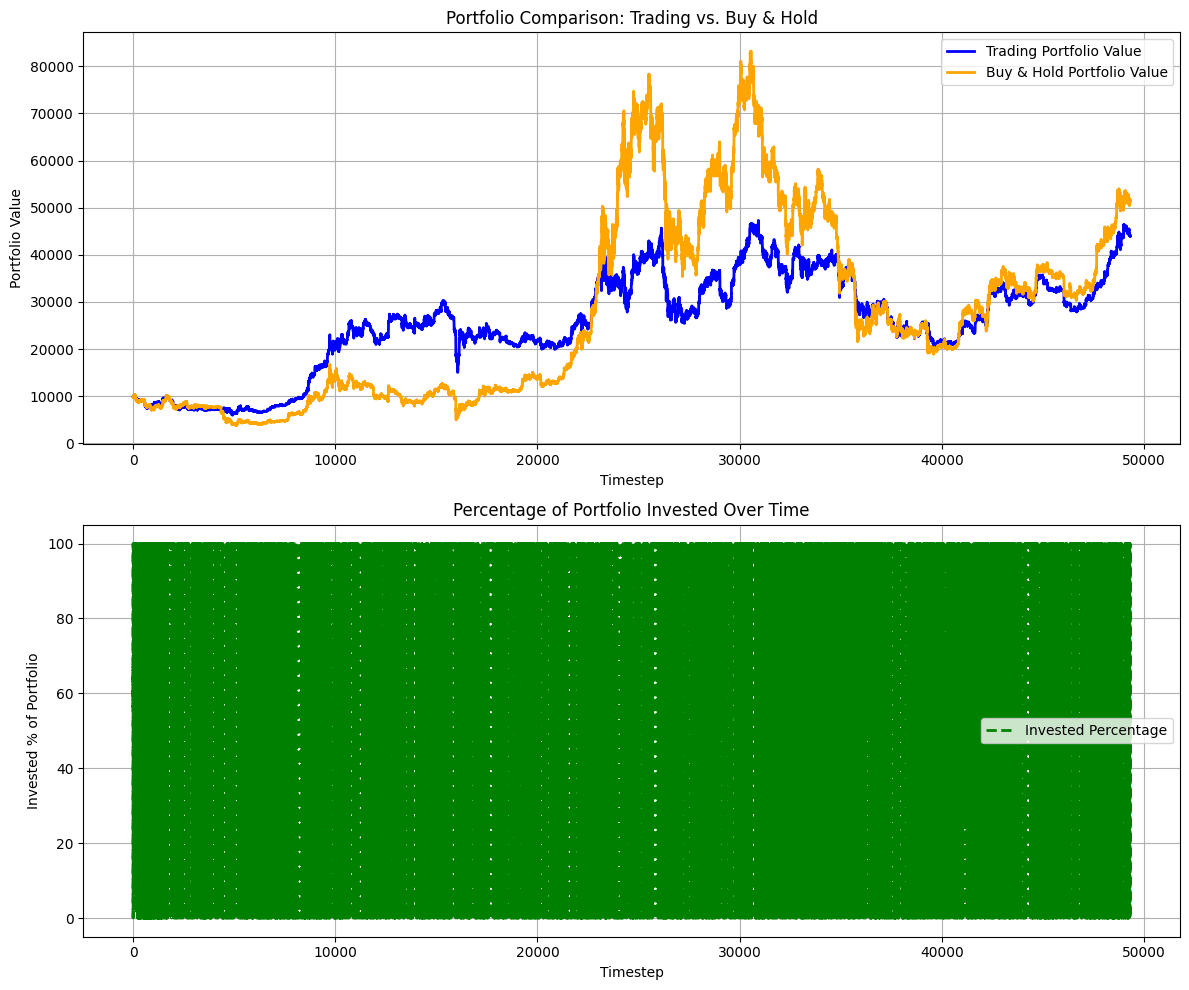

[4, 0, 0, 1, 5, 5, 1, 5, 8, 8, 0, 8, 2, 2, 2, 0, 3, 0, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 3, 5, 5, 1, 3, 7, 0, 3, 4, 0, 5, 5, 5, 1, 5, 1, 1, 2, 2, 5, 5, 1, 1, 1, 5, 1, 1, 5, 3, 3, 0, 5, 5, 5, 5, 5, 1, 1, 1, 3, 1, 1, 1, 5, 5, 5, 3, 5, 3, 5, 4, 5, 5, 7, 3, 5, 5, 7, 5, 1, 1, 3, 4, 3, 3, 7, 3, 3, 4, 3, 4, 4, 7, 7, 3, 5, 5, 5, 3, 5, 7, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 7, 3, 7, 5, 3, 7, 3, 3, 3, 3, 7, 4, 5, 3, 3, 3, 3, 7, 5, 5, 5, 3, 3, 7, 7, 7, 3, 3, 5, 0, 5, 5, 1, 0, 5, 5, 0, 5, 5, 3, 3, 0, 3, 3, 3, 3, 3, 7, 5, 4, 4, 0, 5, 5, 3, 3, 7, 3, 7, 7, 3, 3, 7, 7, 3, 3, 5, 3, 3, 7, 7, 3, 3, 3, 3, 7, 3, 7, 7, 3, 3, 2, 7, 3, 3, 6, 3, 3, 4, 3, 7, 4, 4, 4, 3, 7, 3, 7, 7, 3, 8, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 4, 7, 8, 1, 2, 8, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 7, 7, 3, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 2, 2, 2, 3, 2, 2, 8, 2, 2, 8, 8, 3, 4, 4, 4, 8, 4, 8, 8, 8, 2, 2, 0, 2, 8, 

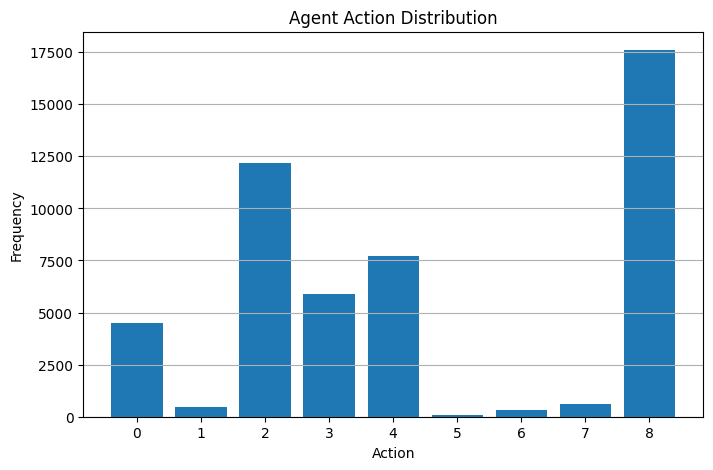

Seed in the environment: 42
Seed in the environment: 42


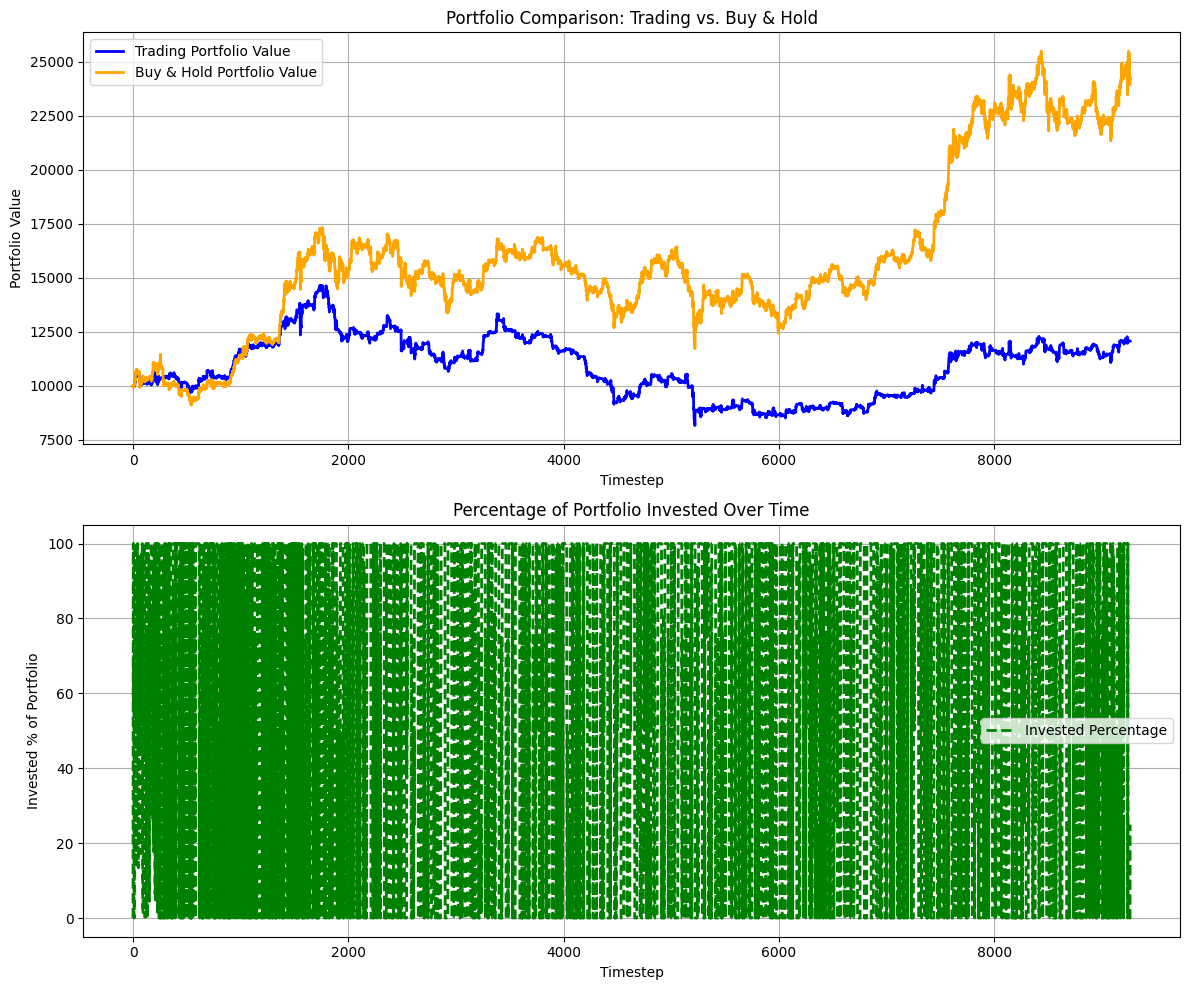

[4, 0, 0, 1, 5, 5, 1, 5, 8, 8, 0, 8, 2, 2, 2, 0, 3, 0, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 2, 1, 5, 3, 1, 5, 1, 3, 4, 3, 3, 5, 5, 5, 5, 5, 5, 5, 1, 1, 2, 2, 1, 5, 5, 1, 1, 1, 5, 5, 3, 3, 0, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 3, 3, 5, 5, 4, 5, 5, 7, 7, 5, 5, 5, 5, 1, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 5, 5, 5, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 7, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 7, 5, 7, 3, 2, 5, 5, 5, 1, 1, 5, 5, 5, 0, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 2, 4, 1, 5, 5, 2, 3, 3, 3, 3, 7, 3, 7, 3, 3, 7, 5, 3, 5, 3, 3, 5, 7, 3, 3, 3, 3, 3, 7, 7, 3, 7, 7, 4, 7, 7, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 7, 4, 7, 7, 7, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 1, 1, 8, 4, 3, 3, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 4, 3, 3, 3, 3, 3, 8, 8, 8, 0, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 0, 3, 7, 8, 8, 8, 8, 8, 3, 0, 3, 3, 3, 2, 2, 2, 8, 0, 8, 8, 3, 8, 8, 2, 2, 2, 8, 2, 2, 8, 8, 7, 2, 2, 3, 2, 4, 3, 8, 

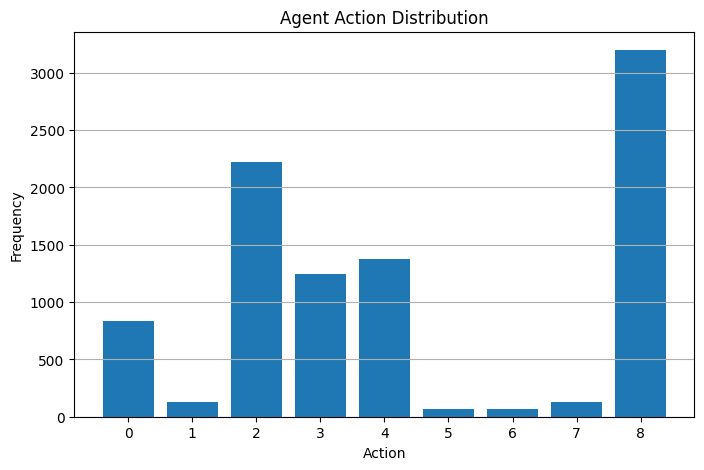

Backtesting Metrics:
final_portfolio_value: 12079.7689
profit: 2079.7689
annualized_return: 0.1956
sharpe_ratio: 0.6545
max_drawdown: -0.4423
win_rate: 0.3195
loss_rate: 0.3087

DQN Agent Strategy Metrics:
final_portfolio_value: 12079.768853361082
profit: 2079.7688533610817
annualized_return: 0.19560003710905316
sharpe_ratio: 0.6544901794453393
max_drawdown: -0.4423456626471187
win_rate: 0.31951640759930916
loss_rate: 0.30872193436960277


In [3]:
try:
    env_dqn, metrics_dqn = dqn_agent_backtest()
    print("\nDQN Agent Strategy Metrics:")
    for k, v in metrics_dqn.items():
        print(f"{k}: {v}")
except Exception as e:
    print("\nDQN Agent backtest failed:", e)
    metrics_dqn = {}

## 4. Strategy Comparison
We now collect metrics from all three strategies into a DataFrame and plot a comparison.


In [ ]:
def safe_get(metrics, key):
    value = metrics.get(key, np.nan)
    if isinstance(value, pd.Series):
        return value.item()
    return value

env_dqn, metrics_dqn = dqn_agent_backtest()

print("\nDQN Metrics:", metrics_dqn)
print("Type:", type(metrics_dqn))


comparison = pd.DataFrame({
    "Strategy": ["Moving Average", "Halving", "DQN Agent"],
    
    "Final Value / Growth": [
        safe_get(metrics_ma, "final_portfolio_value"),
        safe_get(metrics_halving, "final_portfolio_value"),  # <- FIXED HERE
        safe_get(metrics_dqn, "final_portfolio_value")
    ],

    "Profit / Return": [
        safe_get(metrics_ma, "profit"),
        safe_get(metrics_halving, "final_portfolio_value"), 
        safe_get(metrics_dqn, "profit")
    ],

    "Annualized Return": [
        safe_get(metrics_ma, "annualized_return"),
        safe_get(metrics_halving, "annualized_return"),
        safe_get(metrics_dqn, "annualized_return")
    ],

    "Sharpe Ratio": [
        safe_get(metrics_ma, "sharpe_ratio"),
        safe_get(metrics_halving, "sharpe_ratio"),
        safe_get(metrics_dqn, "sharpe_ratio")
    ],

    "Max Drawdown": [
        safe_get(metrics_ma, "max_drawdown"),
        safe_get(metrics_halving, "max_drawdown"),
        safe_get(metrics_dqn, "max_drawdown")
    ],

    "Win Rate": [
        safe_get(metrics_ma, "win_rate"),
        safe_get(metrics_halving, "win_rate"),
        safe_get(metrics_dqn, "win_rate")
    ],

    "Loss Rate": [
        safe_get(metrics_ma, "loss_rate"),
        safe_get(metrics_halving, "loss_rate"),
        safe_get(metrics_dqn, "loss_rate")
    ],
})



print("\nComparison of Strategies:")
print(comparison.round(4))  # Optional: Round the output for readability


Seed in the environment: 42
Seed in the environment: 42


c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.09GB > 2.18GB
  warnings.warn(



DQN Metrics: {'final_portfolio_value': np.float64(12079.768853361082), 'profit': np.float64(2079.7688533610817), 'annualized_return': np.float64(0.19560003710905316), 'sharpe_ratio': np.float64(0.6544901794453393), 'max_drawdown': np.float64(-0.4423456626471187), 'win_rate': np.float64(0.31951640759930916), 'loss_rate': np.float64(0.30872193436960277)}
Type: <class 'dict'>

Comparison of Strategies:
         Strategy  Final Value / Growth  Profit / Return  Annualized Return  \
0  Moving Average          1.496897e+04     4.968967e+03             0.0743   
1         Halving          1.891950e+07     1.891950e+07             1.1100   
2       DQN Agent          1.207977e+04     2.079769e+03             0.1956   

   Sharpe Ratio  Max Drawdown  Win Rate  Loss Rate  
0        0.4514       -0.6699    0.3000     0.7000  
1        8.9486       -0.6181    1.0000     0.0000  
2        0.6545       -0.4423    0.3195     0.3087  


: 

# Plot comparison of Final Value / Growth

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(comparison["Strategy"], comparison["Final Value / Growth"], color=['skyblue', 'orange', 'green'])
plt.title("Comparison: Final Value (or Growth Factor) Across Strategies")
plt.ylabel("Final Value / Growth Factor")
plt.grid(axis='y')
plt.show()

NameError: name 'comparison' is not defined

<Figure size 1000x600 with 0 Axes>